In [401]:
import pandas as pd

In [402]:
import matplotlib.pyplot as plt

In [403]:
import numpy as np

In [404]:
from fastprogress import progress_bar,master_bar

In [405]:
import datetime as dt

In [406]:
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing import *
from tensorflow.keras.utils import *

In [407]:
data=pd.read_excel("data_set.xlsx")

In [408]:
data.shape

(72791, 8)

In [409]:
df=data.copy()

In [410]:
df.DateTime.values

array(['2018-08-16T10:23:36.000000000', '2018-08-16T10:33:55.000000000',
       '2018-08-16T10:43:55.000000000', ...,
       '2018-10-16T16:51:25.000000000', '2018-10-16T16:53:50.000000000',
       '2018-10-16T16:56:36.000000000'], dtype='datetime64[ns]')

In [411]:
df['day'] = df.DateTime.dt.day
df['month'] = df.DateTime.dt.month
df['year'] = df.DateTime.dt.year
df['hour']=df.DateTime.dt.hour
df['weekday']=df.DateTime.dt.weekday
df['time']=(df['DateTime'] - dt.datetime(2018,1,1)).dt.total_seconds()

In [412]:
mapper={}
for i,comp in enumerate(df['Company Id'].unique()):
    mapper[comp]=i+1
mapper
df['comp_code']=df['Company Id'].map(mapper)

In [413]:
df_grp=df.groupby(['Company Id','day','month','weekday'],as_index=True)

In [414]:
df_grp['Level of Fuel'].diff()

0           NaN
1       -19.443
2        -1.942
3        -1.103
4        -1.119
          ...  
72786     0.000
72787     0.000
72788     0.000
72789     0.000
72790     0.000
Name: Level of Fuel, Length: 72791, dtype: float64

In [415]:
df['fuel_consumption']=df_grp['Level of Fuel'].apply(lambda x :abs(x.diff().fillna(0).apply(lambda x:min(x,0)))).values

In [416]:
df['time_elapsed']=df_grp['time'].apply(lambda x :abs(x.diff().fillna(0))).values

In [417]:
df.head(10)

,Company Id,DateTime,ON/OFF,Level of Fuel,PF,KiloWatt,KWH,ErrorCode,day,month,year,hour,weekday,time,comp_code,fuel_consumption,time_elapsed
0,25502921,2018-08-16 10:23:36,0,175.000,0.0,0.0,0.0,0,16,8,2018,10,3,19650216.0,1,0.000,0.0
1,25502921,2018-08-16 10:33:55,0,155.557,0.0,0.0,0.0,0,16,8,2018,10,3,19650835.0,1,19.443,619.0
2,25502921,2018-08-16 10:43:55,0,153.615,0.0,0.0,0.0,0,16,8,2018,10,3,19651435.0,1,1.942,600.0
3,25502921,2018-08-16 10:53:55,0,152.512,0.0,0.0,0.0,0,16,8,2018,10,3,19652035.0,1,1.103,600.0
4,25502921,2018-08-16 11:03:55,0,151.393,0.0,0.0,0.0,0,16,8,2018,11,3,19652635.0,1,1.119,600.0
5,25502921,2018-08-16 11:13:55,0,150.150,0.0,0.0,0.0,0,16,8,2018,11,3,19653235.0,1,1.243,600.0
6,25502921,2018-08-16 11:23:55,0,150.010,0.0,0.0,0.0,0,16,8,2018,11,3,19653835.0,1,0.140,600.0
7,25502921,2018-08-16 11:33:55,0,147.648,0.0,0.0,0.0,0,16,8,2018,11,3,19654435.0,1,2.362,600.0
8,25502921,2018-08-16 11:43:55,0,146.545,0.0,0.0,0.0,0,16,8,2018,11,3,19655035.0,1,1.103,600.0
9,25502921,2018-08-16 11:53:55,0,146.545,0.0,0.0,0.0,0,16,8,2018,11,3,19655635.0,1,0.000,600.0


In [418]:
df.columns

Index(['Company Id', 'DateTime', 'ON/OFF', 'Level of Fuel', 'PF', 'KiloWatt',
       'KWH', 'ErrorCode', 'day', 'month', 'year', 'hour', 'weekday', 'time',
       'comp_code', 'fuel_consumption', 'time_elapsed'],
      dtype='object')

In [419]:
features=['PF','KiloWatt','KWH','fuel_consumption','time_elapsed']

In [420]:
df[features].values.shape

(72791, 5)

In [421]:
transformed_values=df[features].apply(lambda x:np.log(x+1)).values
transformed_values

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  3.01764053,  6.42971948],
       [ 0.        ,  0.        ,  0.        ,  1.07908962,  6.39859493],
       ...,
       [ 0.59056066,  4.40060302, 12.43861427,  0.        ,  4.91265489],
       [ 0.60376943,  4.28908864, 12.43862579,  0.        ,  4.98360662],
       [ 0.61139474,  4.09767235, 12.43863768,  0.        ,  5.11799381]])

In [422]:
X=np.concatenate([transformed_values,to_categorical(df['comp_code']),to_categorical(df['ON/OFF']),to_categorical(df.day),to_categorical(df.hour)],axis=1)
X.shape

(72791, 69)

### Model creation

#### we are using autoencoder to capture the multivariate  feature.

In [302]:
input_layer=Input(X.shape[1])

In [303]:
hidden=Dense(100)(input_layer)

In [304]:
hidden=Dense(100)(hidden)

In [305]:
bottelneck=Dense(10)(hidden)

In [306]:
hidden=Dense(100)(bottelneck)

In [307]:
hidden=Dense(100)(hidden)

In [308]:
output=Dense(X.shape[1])(hidden)

In [309]:
autoenc=Model(inputs=input_layer,outputs=output)

In [310]:
autoenc.compile(loss='mae',metrics=['accuracy'])

In [311]:
autoenc.build(X.shape[1])

In [312]:
autoenc.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 69)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               7000      
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1100      
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_21 (Dense)             (None, 69)                6969

In [313]:
autoenc.fit(x=X,y=X,epochs=20,validation_split=0.1,verbose=1)

Epoch 1/20
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0893 - accuracy: 0.9864 - val_loss: 0.0612 - val_accuracy: 0.9973
Epoch 2/20
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0544 - accuracy: 0.9992 - val_loss: 0.0540 - val_accuracy: 0.9999
Epoch 3/20
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0487 - accuracy: 0.9996 - val_loss: 0.0748 - val_accuracy: 1.0000
Epoch 4/20
2048/2048 [==============================] - 5s 2ms/step - loss: 0.0458 - accuracy: 0.9996 - val_loss: 0.0500 - val_accuracy: 0.9999
Epoch 5/20
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0439 - accuracy: 0.9997 - val_loss: 0.0450 - val_accuracy: 0.9986
Epoch 6/20
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0425 - accuracy: 0.9998 - val_loss: 0.0495 - val_accuracy: 0.9973
Epoch 7/20
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0415 - accuracy: 0.9998 - val_loss: 0.0435 - val_accuracy:

KeyboardInterrupt: 

# Writing the reconstruction loss

### Reconstruction loss for any given observation can be used to set the trend and detect the outliers on a threshold

##### Kindly read ("data_set_hourwise.xlsx") to avoid evaluating regression_loss.

In [485]:
regression_loss=[]
for sample in progress_bar(X):
    regression_loss.append(autoenc.evaluate(np.expand_dims(sample,0),np.expand_dims(sample,0),verbose=0))
# regression_loss

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000001E1BA823950>
Traceback (most recent call last):
  File "C:\Users\VKOTWAL\AppData\Local\conda\conda\envs\tf21\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 538, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\Users\VKOTWAL\AppData\Local\conda\conda\envs\tf21\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
np.array(regression_loss)[:,0]

In [ ]:
df['construction_loss']=np.array(regression_loss)[:,0]

In [317]:
#df.to_excel("data_set_hourwise.xlsx")

In [486]:
df=pd.read_excel("data_set_hourwise.xlsx")

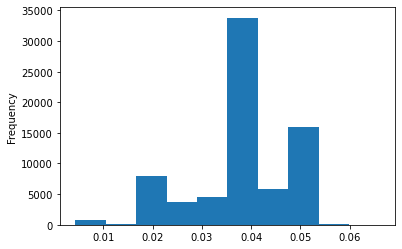

In [430]:
df['construction_loss'].plot.hist()

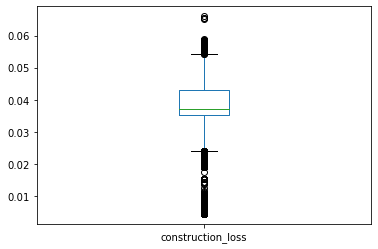

In [431]:
df['construction_loss'].plot.box()

In [432]:
df_grp=df.groupby(['Company Id','day','month','weekday'],as_index=True)

In [433]:
df_grp.get_group(list(df_grp.groups.keys())[0])

,Unnamed: 0,Company Id,DateTime,ON/OFF,Level of Fuel,PF,KiloWatt,KWH,ErrorCode,day,month,year,hour,weekday,time,fuel_consumption,time_elapsed,construction_loss
2522,2522,25502921,2018-10-01 09:06:06,0,50.2250,0.0,0.0,0.0,0,1,10,2018,9,0,23619966,0.0000,0,0.056548
2523,2523,25502921,2018-10-01 09:16:29,0,50.2250,0.0,0.0,0.0,0,1,10,2018,9,0,23620589,0.0000,623,0.048214
2524,2524,25502921,2018-10-01 09:26:30,0,49.1225,0.0,0.0,0.0,0,1,10,2018,9,0,23621190,1.1025,601,0.048182
2525,2525,25502921,2018-10-01 09:36:30,0,48.0025,0.0,0.0,0.0,0,1,10,2018,9,0,23621790,1.1200,600,0.048181
2526,2526,25502921,2018-10-01 09:46:29,0,48.0025,0.0,0.0,0.0,0,1,10,2018,9,0,23622389,0.0000,599,0.048223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2610,2610,25502921,2018-10-01 23:16:29,0,59.6575,0.0,0.0,0.0,0,1,10,2018,23,0,23670989,0.0000,0,0.058125
2611,2611,25502921,2018-10-01 23:26:29,0,59.6575,0.0,0.0,0.0,0,1,10,2018,23,0,23671589,0.0000,600,0.049807
2612,2612,25502921,2018-10-01 23:36:29,0,58.5550,0.0,0.0,0.0,0,1,10,2018,23,0,23672189,1.1025,600,0.049817
2613,2613,25502921,2018-10-01 23:46:29,0,58.5550,0.0,0.0,0.0,0,1,10,2018,23,0,23672789,0.0000,600,0.049807


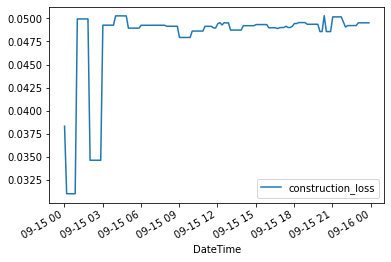

In [434]:
a=df_grp.get_group(list(df_grp.groups.keys())[20]).plot(x="DateTime", y='construction_loss')

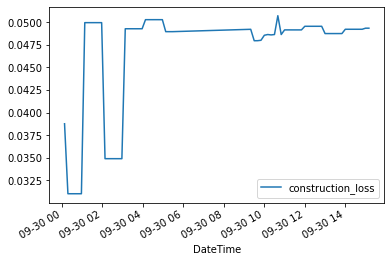

In [435]:
a=df_grp.get_group(list(df_grp.groups.keys())[34]).plot(x="DateTime", y='construction_loss')

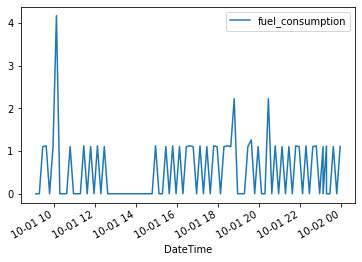

In [436]:
a=df_grp.get_group(list(df_grp.groups.keys())[0]).plot(x="DateTime", y='fuel_consumption')

In [437]:
grp_c=df.groupby('Company Id')

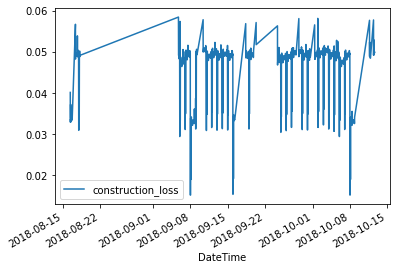

In [438]:
grp_c.get_group(list(grp_c.groups.keys())[0]).plot(x="DateTime", y='construction_loss')

# Company wise  Anamoly visualization

### input the company code {0 to 4} to see the trend

In [472]:
c_code=4 # company code{0-4}

In [473]:
grp_c.get_group(list(grp_c.groups.keys())[c_code])['construction_loss'].describe()

count    31585.000000
mean         0.035579
std          0.007973
min          0.004317
25%          0.035298
50%          0.036069
75%          0.037506
max          0.066058
Name: construction_loss, dtype: float64

In [474]:
mean=grp_c.get_group(list(grp_c.groups.keys())[c_code])['construction_loss'].mean()
std=grp_c.get_group(list(grp_c.groups.keys())[c_code])['construction_loss'].std()
max_thres=mean+std
max_thres

0.04355187857078929

In [475]:
plot_df=grp_c.get_group(list(grp_c.groups.keys())[1])

In [476]:
plot_df.shape

(16306, 18)

In [477]:
plot_df[plot_df['construction_loss']>max_thres]

,Unnamed: 0,Company Id,DateTime,ON/OFF,Level of Fuel,PF,KiloWatt,KWH,ErrorCode,day,month,year,hour,weekday,time,fuel_consumption,time_elapsed,construction_loss
5617,5617,25750275,2018-08-17 01:30:57,1,64.544,0.962,49.5,34452.800781,0,17,8,2018,1,4,19704657,1.008,29,0.043628
5630,5630,25750275,2018-08-17 01:37:27,1,0.000,0.963,49.4,34458.000000,1,17,8,2018,1,4,19705047,64.544,30,0.050822
5637,5637,25750275,2018-08-17 01:40:57,1,63.552,0.963,49.6,34460.898438,0,17,8,2018,1,4,19705257,0.992,29,0.043624
5660,5660,25750275,2018-08-17 01:52:28,1,0.000,0.965,48.9,34470.300781,1,17,8,2018,1,4,19705948,62.544,31,0.050651
5669,5669,25750275,2018-08-17 01:56:58,1,61.312,0.963,49.4,34474.000000,0,17,8,2018,1,4,19706218,1.232,31,0.043647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19733,19733,25750275,2018-10-15 23:09:22,1,0.000,0.912,25.7,53652.101562,1,15,10,2018,23,0,24880162,85.072,29,0.046385
19736,19736,25750275,2018-10-15 23:10:53,1,0.000,0.911,25.6,53652.699219,1,15,10,2018,23,0,24880253,86.848,30,0.046351
19760,19760,25750275,2018-10-15 23:22:52,1,0.000,0.908,26.1,53658.000000,1,15,10,2018,23,0,24880972,84.848,29,0.046435
19771,19771,25750275,2018-10-15 23:28:22,1,0.000,0.909,26.0,53660.300781,1,15,10,2018,23,0,24881302,82.720,30,0.046303


In [478]:
plot_df[plot_df['construction_loss']>max_thres].ErrorCode.value_counts()

0    1160
1     129
Name: ErrorCode, dtype: int64

In [479]:
plot_df[plot_df['construction_loss']<max_thres].ErrorCode.value_counts()

0    14959
1       58
Name: ErrorCode, dtype: int64

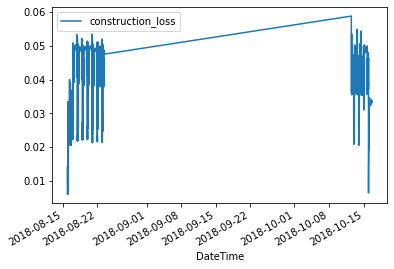

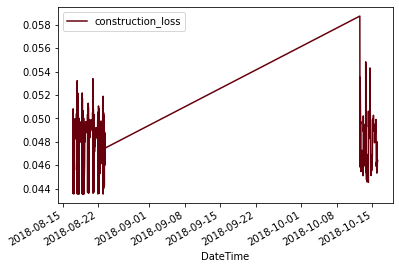

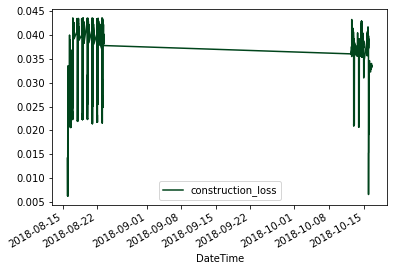

In [480]:
plot_df.plot(x="DateTime", y='construction_loss')
plot_df[plot_df['construction_loss']>max_thres].plot(x="DateTime", y='construction_loss',colormap='Reds_r')
plot_df[plot_df['construction_loss']<max_thres].plot(x="DateTime", y='construction_loss',colormap='Greens_r')

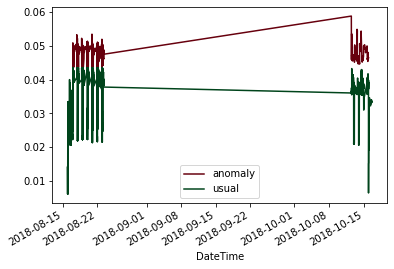

In [481]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.legend(["anomaly", "usual"]);

# plot_df.plot(x="DateTime", y='construction_loss',ax=ax)
plot_df[plot_df['construction_loss']>max_thres].plot(x="DateTime", y='construction_loss',colormap='Reds_r',ax=ax,label='anomaly')
plot_df[plot_df['construction_loss']<max_thres].plot(x="DateTime", y='construction_loss',colormap='Greens_r',ax=ax,label='usual')

C:\Users\VKOTWAL\AppData\Local\conda\conda\envs\tf21\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\VKOTWAL\AppData\Local\conda\conda\envs\tf21\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\VKOTWAL\AppData\Local\conda\conda\envs\tf21\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNu

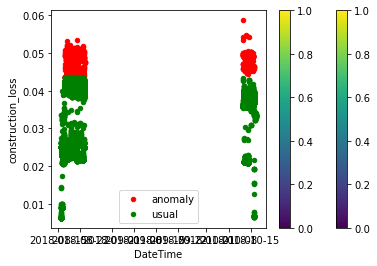

In [482]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.legend(["anomaly", "usual"]);

# plot_df.plot(x="DateTime", y='construction_loss',ax=ax)
plot_df[plot_df['construction_loss']>max_thres].plot.scatter(x="DateTime", y='construction_loss',colormap='Reds_r',ax=ax,label='anomaly',c='r')
plot_df[plot_df['construction_loss']<max_thres].plot.scatter(x="DateTime", y='construction_loss',colormap='Greens_r',ax=ax,label='usual',c='g')

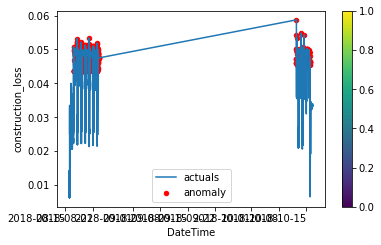

In [483]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.legend(["anomaly", "usual"]);

plot_df.plot(x="DateTime", y='construction_loss',ax=ax,label='actuals')
plot_df[plot_df['construction_loss']>max_thres].plot.scatter(x="DateTime", y='construction_loss',colormap='Reds_r',ax=ax,label='anomaly',c='r')
# plot_df[plot_df['construction_loss']<max_thres].plot.scatter(x="DateTime", y='construction_loss',colormap='Greens_r',ax=ax,label='usual',c='g')

In [492]:
mapper=dict(grp_c['construction_loss'].apply(lambda x:x.mean()+x.std()))
mapper

{25502921: 0.053049843244970724,
 25750275: 0.044419798136301966,
 25921010: 0.04412736708590298,
 25921355: 0.052416497523550126,
 25927159: 0.04355187857078929}

In [497]:
df['max_thres']=df['Company Id'].map(mapper)

In [500]:
df[df.construction_loss>df.max_thres].shape

(6818, 19)

In [501]:
df[df.construction_loss<df.max_thres].shape

(65973, 19)

In [508]:
anomaly=df.apply(lambda x:int(x.construction_loss>x.max_thres),axis=1)

In [509]:
anomaly.value_counts()

0    65973
1     6818
dtype: int64